# Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [201]:
import numpy as np
import matplotlib.pyplot as plt

In [202]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
    return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [203]:
class Chromosome:
    def __init__(
        self, length, array=None
    ):  # if array is None it should be initialized with random binary vector
        self.length = length
        if array is not None:
            self.array = array
        else:
            self.array = np.random.randint(0, 2, length)

    def decode(self, lower_bound, upper_bound, aoi):
        bits_per_argument = upper_bound - lower_bound
        cut_array = self.array[lower_bound:upper_bound]
        value = int("".join(str(i) for i in cut_array.astype(int)), 2)
        normalized_value = min_max_norm(
            value, 0, 2**bits_per_argument - 1, aoi[0], aoi[1]
        )
        return normalized_value

    def mutation(self, probability):
        will_mutate = np.random.random_sample() <= probability
        if will_mutate:
            index = np.random.choice(np.arange(0, self.length))
            self.array[index] = 1 - self.array[index]

    def crossover(self, other):
        index = np.random.choice(np.arange(1, self.length-1))
        children = (
            Chromosome(
                self.length,
                array=np.concatenate((self.array[:index], other.array[index:])),
            ),
            Chromosome(
                self.length,
                array=np.concatenate((other.array[:index], self.array[index:])),
            ),
        )
        return children

In [204]:
# Test
chromosome_one = Chromosome(8, np.array([1, 0, 0, 0, 0, 1, 1, 1]))
chromosome_two = Chromosome(8, np.array([0, 1, 1, 1, 0, 1, 1, 0]))
chromosome_one.crossover(chromosome_two)

(<__main__.Chromosome at 0x1ad32646350>,
 <__main__.Chromosome at 0x1ad3228a380>)

In [213]:
class GeneticAlgorithm:
    def __init__(
        self,
        chromosome_length,
        obj_func_num_args,
        objective_function,
        aoi,
        population_size=1000,
        tournament_size=2,
        mutation_probability=0.05,
        crossover_probability=0.8,
        num_steps=30,
    ):
        assert (
            chromosome_length % obj_func_num_args == 0
        ), "Number of bits for each argument should be equal"
        self.chromosome_length = chromosome_length
        self.obj_func_num_args = obj_func_num_args
        self.bits_per_arg = int(chromosome_length / obj_func_num_args)
        self.objective_function = objective_function
        self.aoi = aoi
        create_pupulation = np.vectorize(Chromosome)
        self.population_size = population_size
        self.population = create_pupulation(np.full(population_size, chromosome_length))
        self.tournament_size = tournament_size
        self.mutation_probability = mutation_probability
        self.crossover_probability = crossover_probability
        self.num_steps = num_steps

    def eval_objective_func(self, chromosome):
        decoded_values = np.zeros(self.obj_func_num_args)
        for i in range(0, self.obj_func_num_args):
            lower_bound = i * self.bits_per_arg
            upper_bound = lower_bound + self.bits_per_arg
            decoded_values[i] = chromosome.decode(lower_bound, upper_bound, self.aoi)
        evaluation = self.objective_function(*decoded_values)
        return evaluation

    def tournament_selection(self):
        selected_chromosomes = np.random.choice(
            self.population, size=self.tournament_size, replace=True
        )
        evaluate_selected_chromosomes = np.vectorize(self.eval_objective_func)
        evaluation = evaluate_selected_chromosomes(selected_chromosomes)
        best_chromosome = selected_chromosomes[np.argmin(evaluation)]
        return best_chromosome

    def reproduce(self, parents):
        new_population = np.zeros(len(parents), dtype=Chromosome)
        for i in range(len(parents)):
            new_population[i] = self.tournament_selection()
            if i % 2 == 1:
                will_crossover = np.random.random_sample() <= self.crossover_probability
                if will_crossover:
                    (new_population[i - 1], new_population[i]) = new_population[
                        i - 1
                    ].crossover(new_population[i])
                new_population[i - 1].mutation(self.mutation_probability)
                new_population[i].mutation(self.mutation_probability)
        return new_population

    def plot_func(self, trace):
        X = np.arange(-2, 3, 0.05)
        Y = np.arange(-4, 2, 0.05)
        X, Y = np.meshgrid(X, Y)
        Z = (
            1.5
            - np.exp(-(X ** (2)) - Y ** (2))
            - 0.5 * np.exp(-((X - 1) ** (2)) - (Y + 2) ** (2))
        )
        plt.figure()
        plt.contour(X, Y, Z, 10)
        cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
        plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
        plt.show()

    def run(self):
        step = 0
        best_evaluations = np.zeros(self.num_steps + 1)
        trace = np.zeros(shape=(self.num_steps + 1, 2))
        evaluate = np.vectorize(self.eval_objective_func)
        evaluation = evaluate(self.population)
        i = np.argmin(evaluation)
        best_evaluations[step] = evaluation[i]
        trace[step][0] = self.population[i].decode(0, self.bits_per_arg, self.aoi)
        trace[step][1] = self.population[i].decode(
            self.bits_per_arg, self.bits_per_arg * 2, self.aoi
        )
        print(f"Best point at the beginning: {trace[step]}; Its evaluation: {best_evaluations[step]}",)
        step = step + 1
        while step <= self.num_steps:
            self.population = self.reproduce(self.population)
            evaluate = np.vectorize(self.eval_objective_func)
            evaluation = evaluate(self.population)
            index_of_best_chromosome = np.argmin(evaluation)
            best_evaluations[step] = evaluation[index_of_best_chromosome]
            trace[step][0] = self.population[index_of_best_chromosome].decode(
                0, self.bits_per_arg, self.aoi
            )
            trace[step][1] = self.population[index_of_best_chromosome].decode(
                self.bits_per_arg, self.bits_per_arg * 2, self.aoi
            )
            print(f"Best point after {step} step: {trace[step]}; Its evaluation: {best_evaluations[step]}")
            step = step + 1
        self.plot_func(trace)


Best point at the beginning: [ 0.10681478 -0.33875546]; Its evaluation: 0.6042754885133416
Best point after 1 step: [ 1.22989593 -0.22278512]; Its evaluation: 1.2701907212341292
Best point after 2 step: [-0.27771844 -3.93383587]; Its evaluation: 1.4976780708622843
Best point after 3 step: [-0.78432569  1.15665151]; Its evaluation: 1.3581524851659106
Best point after 4 step: [-0.78432569  1.1139256 ]; Its evaluation: 1.3437016935365795
Best point after 5 step: [-0.27771844 -0.06408887]; Its evaluation: 0.575719736121892
Best point after 6 step: [-0.27771844 -0.21668142]; Its evaluation: 0.6126268025442871
Best point after 7 step: [-0.27771844 -0.21668142]; Its evaluation: 0.6126268025442871
Best point after 8 step: [-0.27771844 -0.21057772]; Its evaluation: 0.6104078772362257
Best point after 9 step: [-0.21057772  0.1495407 ]; Its evaluation: 0.5633920265585846
Best point after 10 step: [-0.21057772  0.1495407 ]; Its evaluation: 0.5633920265585846
Best point after 11 step: [-0.21057772 

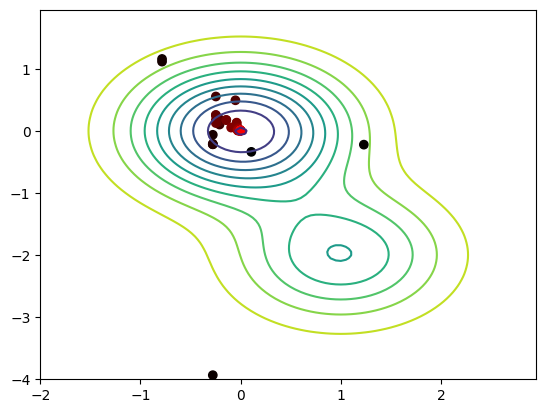

In [216]:
def func(*args):
    return (
        1.5
        - np.exp(-args[0] ** 2 - args[1] ** 2)
        - 0.5 * np.exp(-((args[0] - 1) ** 2) - (args[1] + 2) ** 2)
    )


g1 = GeneticAlgorithm(30, 2, func, [-100, 100], population_size=1000, num_steps=50)
g1.run()